In [76]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [77]:
with open('stopwords.txt') as f:
    stopwords = f.read().replace('\n',' ').split()

In [78]:
with open('training_text.txt', encoding='utf-8') as f:
    text = f.read().replace('\n','')
    print(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([t for t in text if t not in list('0123456789')])
    text = text.replace('”', '').replace('“', '').replace('’', '').lower().split()

text = [w for w in text if w not in stopwords][:2000]

1.0	ll admit raised an eyebrow when saw that pattinson was cast but eat my words he was awesome and hopefully will play the part few more times this film blew me away exciting fast paced surprisingly gritty and genuinely had an awesome story the franchise somehow felt renewed here even if you re not fan of superhero movies you will love this andy serkis was genuinely awesome but when isn he the acting throughout was fantastic with plenty of well known faces great music great special effects ve already booked to see it again 10 10


In [79]:
WINDOW_SIZE = 3
NUM_NEGATIVE_SAMPLES = 3

data = []

#iterate over all words
for idx,center_word in enumerate(text[WINDOW_SIZE-1:-WINDOW_SIZE]):
    
    #iterate over the context words around the center word
    context_words = [context_word for context_word in text[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word]
    for context_word in context_words:
        
        #get words NOT in the current context as negative examples
        data.append([center_word, context_word, 1])
        negative_samples = np.random.choice([w for w in text[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], NUM_NEGATIVE_SAMPLES)
        
        for negative_samp in negative_samples:
            
            #add a training row
            data.append([center_word, negative_samp, 0])

In [80]:
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)

In [81]:
df

,center_word,context_word,label
0,raised,fantastic,0
1,raised,renewed,0
2,raised,pattinson,0
3,raised,awesome,0
4,raised,gritty,0
5,raised,away,0
6,raised,eyebrow,1
7,raised,well,0
8,raised,hopefully,0
9,raised,andy,0


In [82]:
def sigmoid(v, scale=1):
    return 1 / (1 + np.exp(-scale*v))

In [83]:
def update_embeddings(df, main_embeddings, context_embeddings, learning_rate, debug=False):
    
    #get differences between main embeddings and corresponding context embeddings
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    diffs = context_embeddings_context - main_embeddings_center
    
    #get similarities, scores, and errors between main embeddings and corresponding context embeddings
    dot_prods = np.sum(main_embeddings_center * context_embeddings_context, axis=1)
    scores = sigmoid(dot_prods)
    errors = (df.label - scores).values.reshape(-1,1)
    
    #calculate updates
    updates = diffs*errors*learning_rate
    updates_df = pd.DataFrame(data=updates)
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()
    
    if debug:
        plot_words(debug)
    
    #apply updates
    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]
    
    #normalize embeddings
    main_embeddings = normalize_data(main_embeddings)
    context_embeddings = normalize_data(context_embeddings)
    
    #return the updated embeddings
    return main_embeddings, context_embeddings

In [84]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

In [85]:
def plot_words(debug):
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    ###################################
    
    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    plt.show()

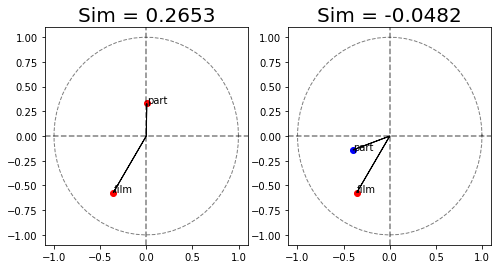

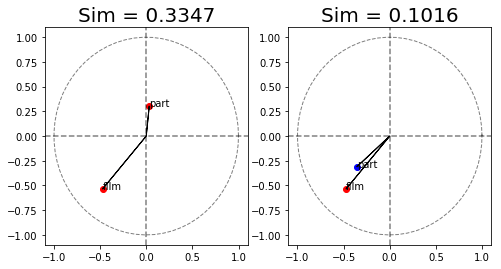

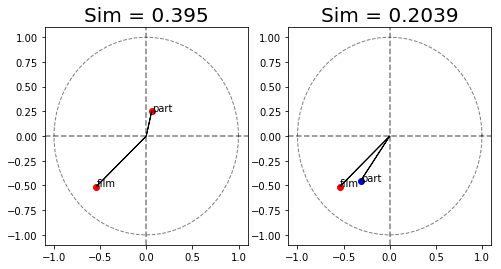

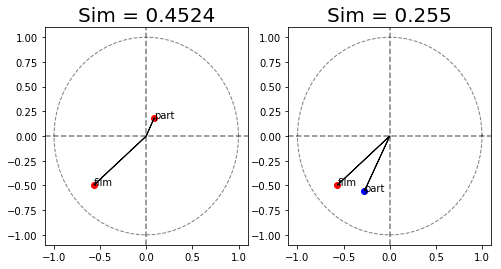

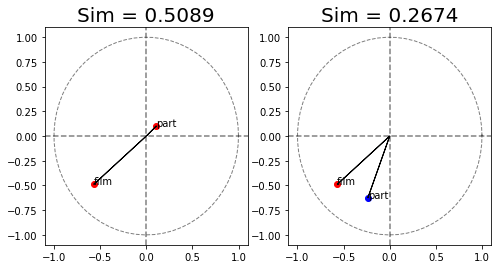

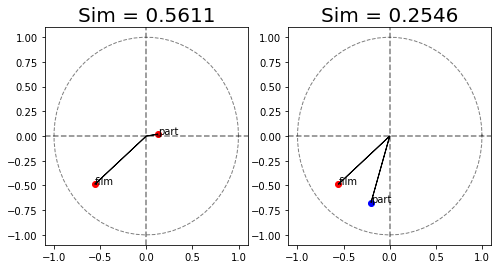

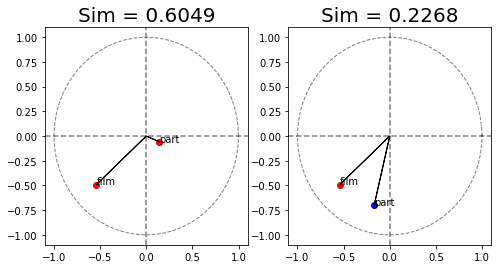

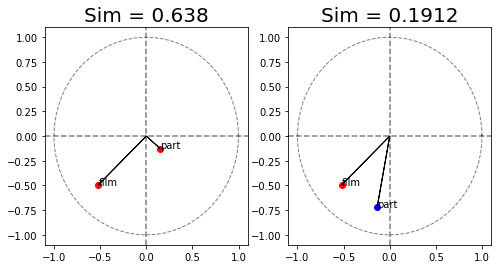

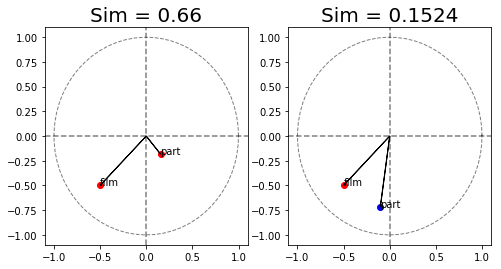

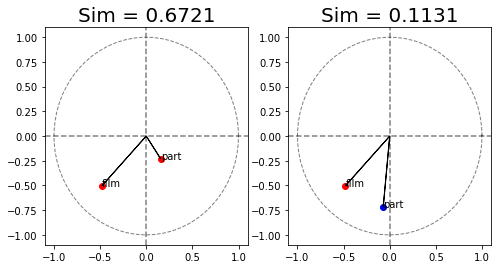

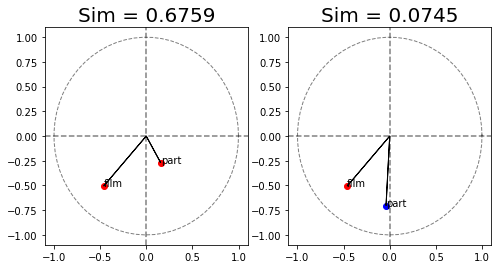

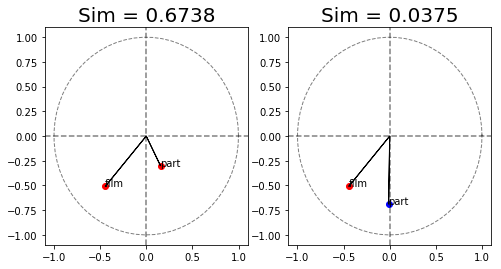

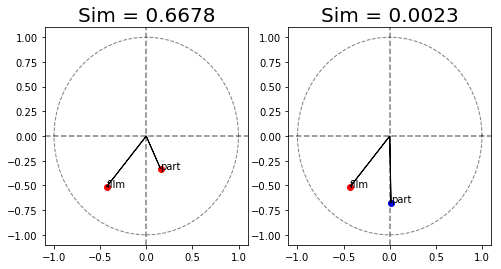

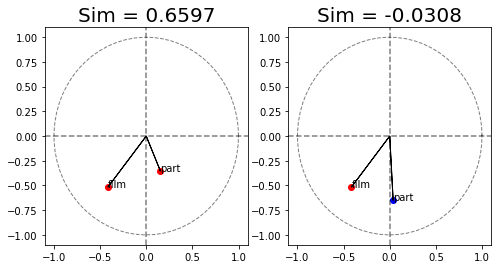

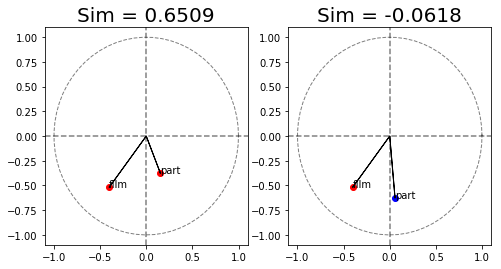

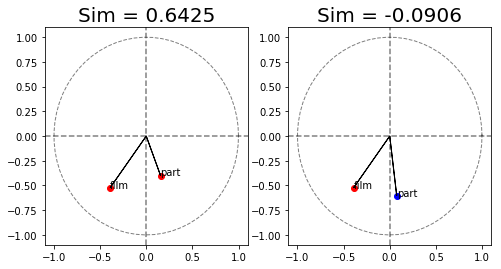

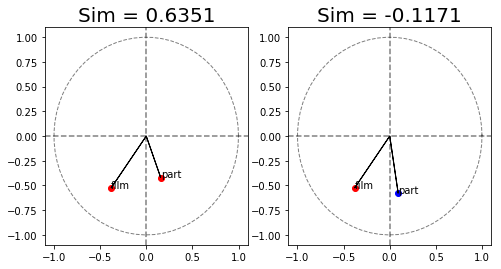

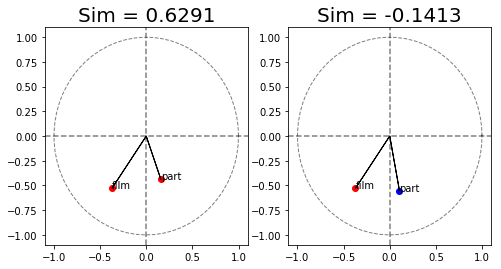

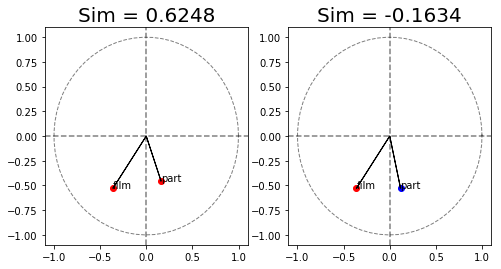

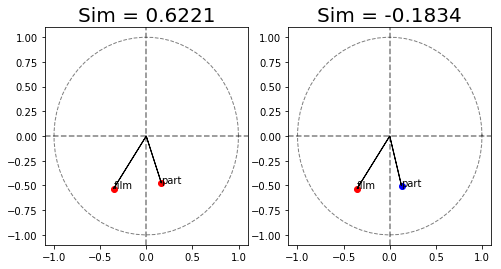

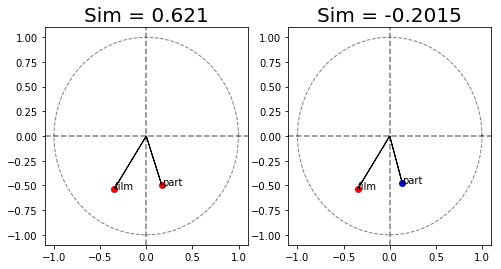

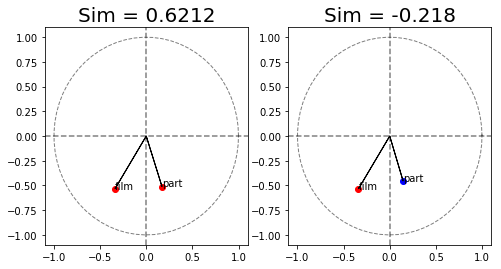

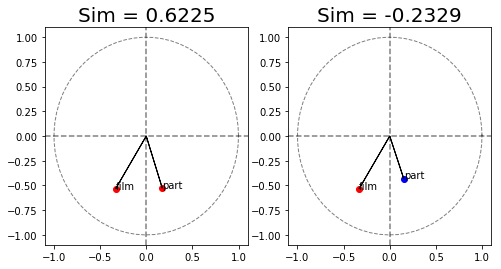

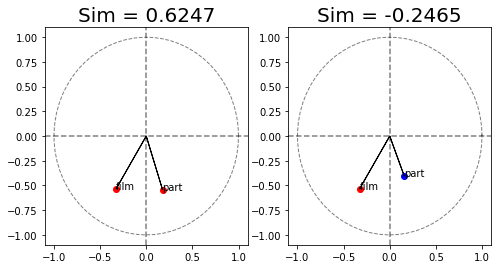

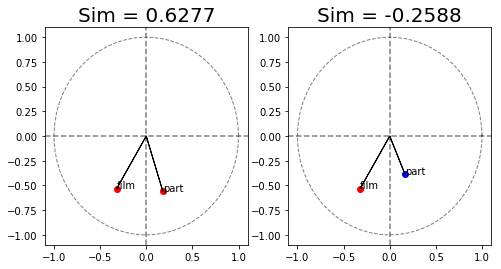

In [86]:
EMBEDDING_SIZE = 5

main_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((main_embeddings**2).sum(axis=1)).reshape(-1,1)
main_embeddings = main_embeddings / row_norms

context_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data=main_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)

for _ in range(25):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.1, ['film', 'part'])

In [87]:
L = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            L.append((w1,w2,sim))
sorted([item for item in L if item[0] == 'film'], key=lambda t: -t[2])[:10]

[('film', 'throughout', 0.9127433438689372),
 ('film', 'times', 0.9068453950077273),
 ('film', 'away', 0.8751727010678204),
 ('film', 'blew', 0.8644001844935941),
 ('film', 'fantastic', 0.8200388717933635),
 ('film', 're', 0.7913674781697408),
 ('film', 'fast', 0.7238319853517416),
 ('film', 'well', 0.6750423032654701),
 ('film', 'effects', 0.6689152880122077),
 ('film', 'awesome', 0.6603239497188965)]

In [88]:
from sklearn.decomposition import PCA

In [89]:
pca = PCA(n_components=2)
transf_embeddings = pca.fit_transform(main_embeddings.values)
words_used = main_embeddings.index

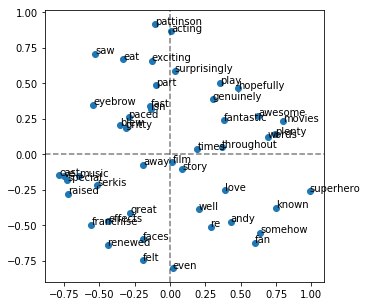

In [90]:
plt.figure(figsize=(5,5))
plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

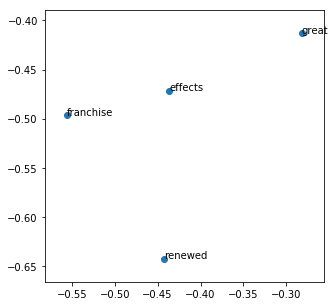

In [91]:
plt.figure(figsize=(5,5))

chosen_idxs = (transf_embeddings[:,0] < -.25) & (transf_embeddings[:,1] < -0.4)
transf_embeddings = transf_embeddings[chosen_idxs]
words_used = words_used[chosen_idxs]

plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))